In [1]:
# Import the required libraries

import os
import glob
import numpy as np
import matplotlib.pyplot as plt

from os import path

from astroquery.astrometry_net import AstrometryNet

from photutils.aperture import SkyCircularAperture, CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry

from astropy.io import fits
from astropy.wcs import WCS
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.visualization import simple_norm, ImageNormalize
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization.stretch import SinhStretch, LinearStretch
from astropy.visualization import (MinMaxInterval, SqrtStretch, ImageNormalize)

In [2]:
# User inputs

AstrometryNet_key = 'edqxeasvvonajjpl'

Target_RA = 194.0849
Target_DEC = 21.2909

Ref_RA = 194.1270
Ref_DEC = 21.2909

ap_size = 10 # aperture size, in pixels, 5
an_small = 20 # size of inner ring of annulus, in pixels, 10
an_large = 30 #size of outer ring of annulus, in pixels, 15
imsz = 150 # number of pixels from the middle to the edge of the image, in x and y

plotting = True

plotpath = "Plot/" #path where you want to save the lightcurve and csv
fitpath = "" #path where the fits files are

# Names of the output files
output_file = "Differential_Photometry.txt"

In [3]:
# Plate Solve the FIT file

def AstrometryNet_Plate_Solve(AstrometryNet_key = None, FIT_File = None, Target_RA = None, Target_DEC = None, Ref_RA = None, Ref_DEC = None):

    ast = AstrometryNet()
    ast.api_key = AstrometryNet_key

    try_again = True
    submission_id = None

    try:
        while try_again:
            try:
                if not submission_id:
                    wcs_header = ast.solve_from_image(FIT_File,
                                                    submission_id = submission_id)
                else:
                    wcs_header = ast.monitor_submission(submission_id,
                                                        solve_timeout = 3000000000000)
            except TimeoutError as e:
                submission_id = e.args[1]
            else:
                # got a result, so terminate
                try_again = False

            w = WCS(wcs_header)

        Target_Pix = w.wcs_world2pix(Target_RA, Target_DEC, 1)

        Ref_Pix = w.wcs_world2pix(Ref_RA, Ref_DEC, 1)

        # Return the locations of the target star and the reference star in pixels

        return(Target_Pix, Ref_Pix)

    except TimeoutError:
        return(999,999)

In [4]:
def star_counts(pixels, data):

    """ Star Counts

    Using aperture photometry to find the number of counts measured from a star.

    Args:
            pixels (array): numpy vector. Location of the target star in pixels.
            data (array): numpy 2D array. Image data of the star from the fits file.
            plotting: wheather to plot photometry rings

    Returns:
            float: time of the observation [MJD], instrument counts from the star
    """

    #Getting the mean background 
    aperture = CircularAperture(pixels, r=ap_size)
    annulus_aperture = CircularAnnulus(pixels, r_in=an_small, r_out=an_large)
    aperstats = ApertureStats(data, annulus_aperture)
    bkg_mean = aperstats.mean

    #Getting the aperture area
    phot_table = aperture_photometry(data, aperture)
    aperture_area = aperture.area_overlap(data)

    #Getting the photometry within the aperture
    total_bkg = bkg_mean * aperture_area
    phot_bkgsub = phot_table['aperture_sum'] - total_bkg
    return phot_bkgsub, aperture, annulus_aperture #total counts within the aperture, aperture object, annulus_object

In [ ]:
#files = sorted(glob.glob(fitpath+'/*.fit'))

files = sorted(glob.glob('*.fit'))

#print(len(files))

relstars_lst = []
mjds_lst = []

# If Output.txt exists
if path.isfile('Differential_Photometry.txt') == True:

    # Load in Output.txt
    info = np.loadtxt('Differential_Photometry.txt', skiprows = 1, dtype = str)

for i in range(len(files)):

    print(files[i])
            
    print("\n")

    info = np.loadtxt('Differential_Photometry.txt', skiprows = 1, dtype = str)

    if path.isfile('Differential_Photometry.txt') == True:

        # If info is a 1D array
        if len(info.shape) == 1:

            # Store the names of the recorded light curves in Output.txt
            name = info[0]

        # If info is a 2D array
        if len(info.shape) == 2:

            # Store the names of the recorded light curves in Output.txt
            name = info[:,0]

        # If the name of the light curve is not recorded in Differential_Photometry.txt, run the function
        if str(files[i]) not in name:

            #importing the fits file and extracting data

            FIT_File = get_pkg_data_filename(files[i])
            
            (Target_Pix, Ref_Pix) = AstrometryNet_Plate_Solve(AstrometryNet_key, FIT_File, Target_RA, Target_DEC, Ref_RA, Ref_DEC)

            image_data = fits.getdata(FIT_File, header=True)
            data = image_data[0]
            hdr = image_data[1]

            #Extracting the time from the image header and converting to MJD
            time = hdr['DATE-OBS']
            #print(time)
            t = Time(time, format='isot', scale='utc')

            # Store the time [MJD] of each FIT file in an array
            mjds_lst.append(t.mjd)

            if (Target_Pix, Ref_Pix) == (999,999):
                
                output = (files[i], t.mjd, "999", "999", "999")

            else: 

                #Getting more precise pixel location by measuring brightness
                """
                #boxsz = 20 #size of the test box, in pixels
                #small_data = data[limx-boxsz:limx+boxsz, limy-imsz:limy+boxsz]
                """
                #Shrinking the data to a reasonable size
                limx = data.shape[0]//2
                limy = data.shape[1]//2
                small_data = data[limx-imsz:limx+imsz, limy-imsz:limy+imsz]
                small_pixels = [Target_Pix[0]-limy+imsz, Target_Pix[1]-limx+imsz]
                small_refpixels = [Ref_Pix[0]-limy+imsz, Ref_Pix[1]-limx+imsz]
                
                #Checking that the location in pixels is correct by plotting
                norm = simple_norm(small_data, 'sqrt', percent=99)
        
                #Getting the instrument counts for the star and the reference star
                star_cts, star_aperture, star_annulus = star_counts(small_pixels, small_data)
                refstar_cts, refstar_aperture, refstar_annulus = star_counts(small_refpixels, small_data)

                #Relative counts (star - reference star)
                rel_star_cts = star_cts - refstar_cts
                relstars_lst.append(rel_star_cts[0])

                output = (files[i], t.mjd, rel_star_cts[0], star_cts[0], refstar_cts[0])         

                if plotting == True:

                    plt.figure()
                    plt.imshow(small_data, norm=norm)
                    #plt.scatter(small_pixels[0], small_pixels[1], color='w', marker='*', s=2)
                    plt.gca().invert_yaxis()


                    #Plotting the annulus and aperture as a check
                    ap_patches = star_aperture.plot(color='white', lw=2,
                                            label='Star Annulus')
                    ann_patches = star_annulus.plot(color='red', lw=2,
                                                        label='Background Annulus')
                    handles = (ap_patches[0], ann_patches[0])
                    plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
                            handles=handles, prop={'weight': 'bold', 'size': 11})

                    ref_ap_patches = refstar_aperture.plot(color='white', lw=2,
                                            label='Star Annulus')
                    ref_ann_patches = refstar_annulus.plot(color='red', lw=2,
                                                        label='Background Annulus')

                    plt.title(files[i])

                    plt.xlabel("x [pixels]")
                    plt.ylabel("y [pixels]")

                    plt.savefig(fname = plotpath + files[i] + ".png", dpi = 200)

                    plt.close()

            if not path.exists(output_file):
               with open(output_file,'a+') as myfile:
                    myfile.write("File_Name, Observation_Time_MJD, Relative_Star_Counts, Target_Star_Counts, Reference_Star_Counts" + "\n")

            with open(output_file, "a+") as myfile: 
                myfile.write(' '.join(str(e) for e in output) + "\n")

    else: 

        FIT_File = get_pkg_data_filename(files[i])
            
        (Target_Pix, Ref_Pix) = AstrometryNet_Plate_Solve(AstrometryNet_key, FIT_File, Target_RA, Target_DEC, Ref_RA, Ref_DEC)

        image_data = fits.getdata(FIT_File, header=True)
        data = image_data[0]
        hdr = image_data[1]

        #Extracting the time from the image header and converting to MJD
        time = hdr['DATE-OBS']
        #print(time)
        t = Time(time, format='isot', scale='utc')

        # Store the time [MJD] of each FIT file in an array
        mjds_lst.append(t.mjd)

        if (Target_Pix, Ref_Pix) == (999,999):
                
            output = (files[i], t.mjd, "999", "999", "999")

        else: 

            #Getting more precise pixel location by measuring brightness
            """
            #boxsz = 20 #size of the test box, in pixels
            #small_data = data[limx-boxsz:limx+boxsz, limy-imsz:limy+boxsz]
            """
            #Shrinking the data to a reasonable size
            limx = data.shape[0]//2
            limy = data.shape[1]//2
            small_data = data[limx-imsz:limx+imsz, limy-imsz:limy+imsz]
            small_pixels = [Target_Pix[0]-limy+imsz, Target_Pix[1]-limx+imsz]
            small_refpixels = [Ref_Pix[0]-limy+imsz, Ref_Pix[1]-limx+imsz]
            
            #Checking that the location in pixels is correct by plotting
            norm = simple_norm(small_data, 'sqrt', percent=99)
        
            #Getting the instrument counts for the star and the reference star
            star_cts, star_aperture, star_annulus = star_counts(small_pixels, small_data)
            refstar_cts, refstar_aperture, refstar_annulus = star_counts(small_refpixels, small_data)

            #Relative counts (star - reference star)
            rel_star_cts = star_cts - refstar_cts
            relstars_lst.append(rel_star_cts[0])

            output = (files[i], t.mjd, rel_star_cts[0], star_cts[0], refstar_cts[0])  

            if plotting == True:

                plt.figure()
                plt.imshow(small_data, norm=norm)
                #plt.scatter(small_pixels[0], small_pixels[1], color='w', marker='*', s=2)
                plt.gca().invert_yaxis()


                #Plotting the annulus and aperture as a check
                ap_patches = star_aperture.plot(color='white', lw=2,
                                        label='Star Annulus')
                ann_patches = star_annulus.plot(color='red', lw=2,
                                                    label='Background Annulus')
                handles = (ap_patches[0], ann_patches[0])
                plt.legend(loc=(0.17, 0.05), facecolor='#458989', labelcolor='white',
                        handles=handles, prop={'weight': 'bold', 'size': 11})

                ref_ap_patches = refstar_aperture.plot(color='white', lw=2,
                                        label='Star Annulus')
                ref_ann_patches = refstar_annulus.plot(color='red', lw=2,
                                                    label='Background Annulus')

                plt.title(files[i])

                plt.xlabel("x [pixels]")
                plt.ylabel("y [pixels]")

                plt.savefig(fname = plotpath + files[i] + ".png", dpi = 200)

                plt.close()

        if not path.exists(output_file):
           with open(output_file,'a+') as myfile:
                    myfile.write("File_Name, Observation_Time_MJD, Relative_Star_Counts, Target_Star_Counts, Reference_Star_Counts" + "\n")

        with open(output_file, "a+") as myfile: 
            myfile.write(' '.join(str(e) for e in output) + "\n")

    print("\n")

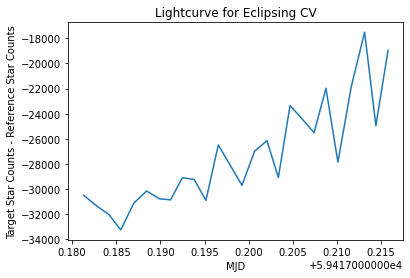

In [25]:
data = np.genfromtxt('Differential_Photometry.txt', skip_header = 1, usecols = (1,2))

plt.figure()
plt.plot(data[:,0], data[:,1])
plt.xlabel("MJD")
plt.ylabel("Target Star Counts - Reference Star Counts")
plt.title("Lightcurve for Eclipsing CV")

plt.savefig(fname = "Lightcurve", dpi = 200)